In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
noise_fold = 0
cam_idx = 1
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold, cam_idx=cam_idx)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [3]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

In [4]:
# func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}
func_dict = {'rnn': contrastive_functions.run_rnn}

fpath = '../data/SPK20220308/neuron_num_results/'

num_repeats = 10
# num_neuron_list = np.arange(2,51,4)
num_neuron_list = [6,10,14,20,30,40]
# num_neuron_list = [10]


num_neuron_results_dict = {'num_neuron_list': num_neuron_list, 'num_repeats': num_repeats, 'moise_fold': noise_fold}
for repeat_idx in range(num_repeats):
    rng = np.random.default_rng(repeat_idx) # new set of shuffled neurons seeded by repeat_idx
    random_units = rng.choice(range(85), size=87).astype(str)

    num_neuron_results_dict[f'repeat_{repeat_idx}'] = {'random_units': random_units}
    for num_neurons in num_neuron_list:
        neuron_subset = random_units[:num_neurons]

        # Filter neural_df with task info to random subset of neurons
        task_unit_mask = np.in1d(task_neural_df['unit'].values, neuron_subset)
        layout_mask = task_neural_df['unit'].str.contains(pat='layout')

        task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

        # Filter neural_df without task info to random subset of neurons
        notask_unit_mask = np.in1d(notask_neural_df['unit'].values, neuron_subset)
        notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

        df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4, 'flip_outputs': True}, # num_cat = number of categorical features
                   'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0, 'flip_outputs': True}}
        

        decode_results = dict()
        for func_name, func in func_dict.items():
            decode_results[func_name] = dict()
            for df_type, pred_df in df_dict.items():
                print(f'{func_name}_{df_type} num_neurons: {num_neurons}; repeat {repeat_idx}')

                model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                       window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col, flip_outputs=pred_df['flip_outputs'])

                decode_results[func_name][df_type] = res_dict

                # Save results on every loop in case early stop
                num_neuron_results_dict[f'repeat_{repeat_idx}'][f'num_neuron_{num_neurons}'] = decode_results
                #Save metadata
                output = open(f'{fpath}num_neuron_results_fold0_10repeats_cam1.pkl', 'wb')
                pickle.dump(num_neuron_results_dict, output)
                output.close()

                if func_name == 'rnn':
                    torch.save(model.state_dict(), f'{fpath}models/{df_type}_neurons{num_neurons}_repeat{repeat_idx}.pt')





rnn_task num_neurons: 6; repeat 0
**********
Epoch: 10/1000 ... Train Loss: 1.0303  ... Validation Loss: 1.0074
***..*....
Epoch: 20/1000 ... Train Loss: 0.8615  ... Validation Loss: 0.9753
.. Early Stop; Min Epoch: 16
rnn_notask num_neurons: 6; repeat 0
******.*..
Epoch: 10/1000 ... Train Loss: 0.3088  ... Validation Loss: 0.3180
.... Early Stop; Min Epoch: 8
rnn_task num_neurons: 10; repeat 0
*********.
Epoch: 10/1000 ... Train Loss: 0.9653  ... Validation Loss: 1.0418
.***......
Epoch: 20/1000 ... Train Loss: 0.8302  ... Validation Loss: 0.9815
 Early Stop; Min Epoch: 14
rnn_notask num_neurons: 10; repeat 0
**********
Epoch: 10/1000 ... Train Loss: 0.2652  ... Validation Loss: 0.2717
...... Early Stop; Min Epoch: 10
rnn_task num_neurons: 14; repeat 0
**********
Epoch: 10/1000 ... Train Loss: 0.9536  ... Validation Loss: 0.9915
*...*.....
Epoch: 20/1000 ... Train Loss: 0.8174  ... Validation Loss: 0.9448
. Early Stop; Min Epoch: 15
rnn_notask num_neurons: 14; repeat 0
*********.
Epoc

In [13]:
num_neuron_dict = num_neuron_results_dict.copy()

num_repeats = num_neuron_dict['num_repeats']
num_neuron_list = num_neuron_dict['num_neuron_list'][:-1]

task_res = list()
notask_res = list()
for repeat_idx in range(num_repeats):
    task_test_corr = list()
    notask_test_corr = list()
    for num_neurons in num_neuron_list:
        res_dict = num_neuron_dict[f'repeat_{repeat_idx}'][f'num_neuron_{num_neurons}']
        task_test_corr.append(np.stack(res_dict['rnn']['task']['test_corr']))
        notask_test_corr.append(np.stack(res_dict['rnn']['notask']['test_corr']))

    task_res.append(np.stack(task_test_corr))
    notask_res.append(np.stack(notask_test_corr))

task_res = np.stack(task_res)
notask_res = np.stack(notask_res)


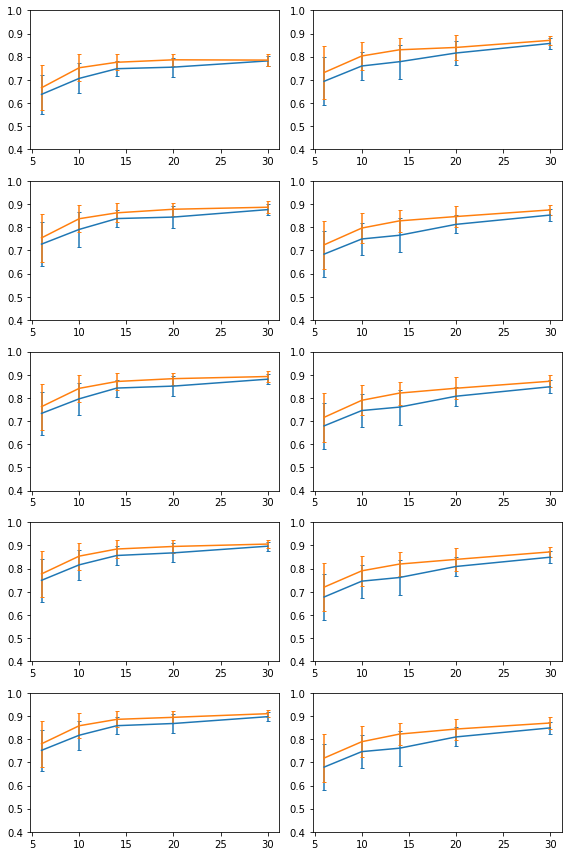

In [14]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

plt.figure(figsize=(8,12))
for plot_idx in range(10):
    plt.subplot(5,2,plot_idx+1)
    plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx], capsize=2)
    plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx], capsize=2)


    plt.tight_layout()
    plt.ylim(0.4,1)

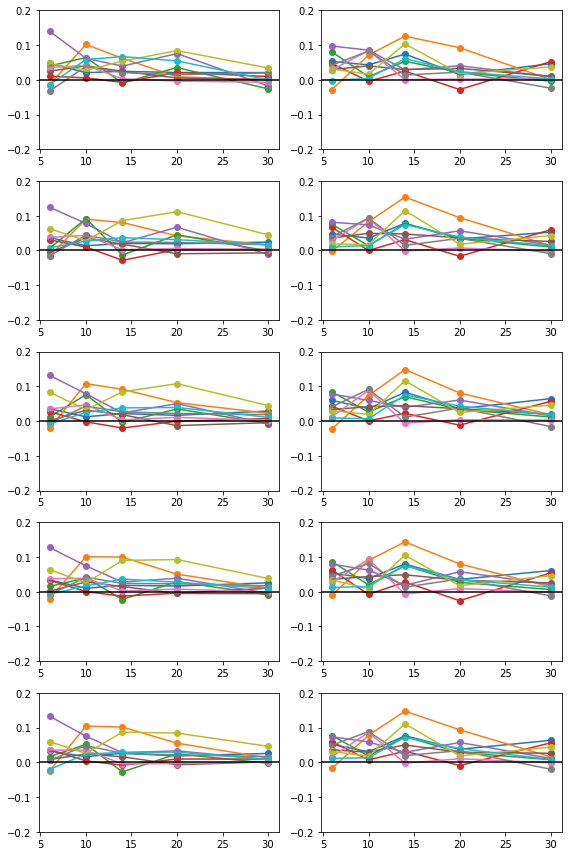

In [15]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

plt.figure(figsize=(8,12))
for plot_idx in range(10):
    plt.subplot(5,2,plot_idx+1)
    # plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx])
    # plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx])
    for repeat_idx in range(num_repeats):

        corr_diff = task_res[repeat_idx, :, plot_idx] - notask_res[repeat_idx, :, plot_idx]
        # plt.plot(task_res[repeat_idx, :, plot_idx], color=f'C{repeat_idx}')
        # plt.plot(notask_res[repeat_idx, :, plot_idx], color=f'C{repeat_idx}')
        plt.scatter(num_neuron_list, corr_diff)
        plt.plot(num_neuron_list, corr_diff)

    plt.tight_layout()
    plt.axhline(y=0, color='k')
    plt.ylim(-0.2, 0.2)